# Travaux existants
  - https://www.kaggle.com/code/dennisho/blackjack-analysis

# Contexte

Le Blackjack, un des jeux de casino les plus populaires, met en scène une confrontation entre joueur(s) et croupier. Le principe est simple : obtenir une main supérieure à celle du croupier sans dépasser 21 points. La particularité du jeu réside dans son déroulement - le joueur agit en premier, ce qui confère naturellement un avantage statistique au casino.

Bien que diverses stratégies mathématiquement prouvées existent pour optimiser les chances du joueur, notre étude adopte une approche différente. Nous nous concentrons sur l'analyse d'un vaste ensemble de données de 50 millions de mains de Blackjack pour développer un modèle prédictif. L'objectif est d'anticiper l'issue d'une partie (victoire, défaite ou égalité) en se basant uniquement sur les données statistiques.

Notre jeu de données est issu de simulations intégrant certaines variations par rapport aux règles classiques du Blackjack. Ces spécificités sont documentées et prises en compte dans notre analyse. Pour la compréhension de cette étude, une connaissance basique des règles suffit, bien que des ressources détaillées soient disponibles pour approfondir les mécaniques du jeu.

Cette recherche s'inscrit dans une démarche de classification multiclasse, exploitant un volume de données conséquent pour extraire des patterns significatifs et développer un modèle prédictif robuste.

# Exploration des données

In [88]:
!python -m pip install pandas seaborn numpy kagglehub scikit-learn matplotlib imbalanced-learn

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from math import nan
import warnings

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Plutôt que d'utiliser les 50 millions de mains disponibles, ce qui demanderait beaucoup trop de ressources, nous avons choisi de travailler sur un échantillon de 30 000 mains. Cela nous permet d'avoir suffisamment de données pour une analyse pertinente, tout en gardant des temps de calcul raisonnables.

Tout d'abord, téléchargons le dataset grâce au module Kaggle

In [3]:
raw_data_path = kagglehub.dataset_download("dennisho/blackjack-hands")

print("Téléchargement du dataset réussi")

Téléchargement du dataset réussi


In [4]:
data = pd.read_csv(
  f"{raw_data_path}/blackjack_simulator.csv",
  sep=",",
  nrows=30000
)

print("Dataset chargé")

Dataset chargé


Dans notre première phase de nettoyage des données, nous allons :


1.   Supprimer la colonne 'shoe_id' qui n'apporte rien à notre analyse
2.   Garder les variables 'run_count' et 'true_count' qui serviront pour notre modèle
3.   Corriger le format des données en transformant les chaînes de caractères qui représentent des listes en vraies listes Python

Un premier examen des données nous montre qu'il n'y a pas de valeurs manquantes, ce qui est une bonne nouvelle pour la suite. On note cependant une particularité : quand un joueur sépare ses cartes (split), l'enregistrement des actions n'est pas tout à fait standard. Nous devrons corriger cela plus tard dans notre analyse.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30000 non-null  int64  
 1   cards_remaining     30000 non-null  int64  
 2   dealer_up           30000 non-null  int64  
 3   initial_hand        30000 non-null  object 
 4   dealer_final        30000 non-null  object 
 5   dealer_final_value  30000 non-null  object 
 6   player_final        30000 non-null  object 
 7   player_final_value  30000 non-null  object 
 8   actions_taken       30000 non-null  object 
 9   run_count           30000 non-null  int64  
 10  true_count          30000 non-null  int64  
 11  win                 30000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


Aucun objets null n'est présent.

In [6]:
type(data['initial_hand'][1]), type(data['dealer_final'][1])

(str, str)

On voit que les listes des mains du joueur et du dealer sont en fait des strings, nous allons donc devoir nettoyer les données pour qu'elles soient dans un format favorable à l'entraînement.

# Nettoyage et restructuration des données

En examinant nos données de plus près, nous avons remarqué que certaines colonnes contenaient des listes, mais sous forme de texte. Par exemple, les cartes du joueur étaient enregistrées comme des chaînes de caractères plutôt que comme de vraies listes Python. Pour corriger cela, nous avons converti cinq colonnes importantes :

- Les cartes initiales
- Les cartes finales du croupier
- Les cartes finales du joueur
- Les valeurs finales des mains du joueur
- Les actions prises pendant le jeu

In [7]:
data['initial_hand'] = data['initial_hand'].apply(lambda x: ast.literal_eval(x))
data['dealer_final'] = data['dealer_final'].apply(lambda x: ast.literal_eval(x))
data['player_final'] = data['player_final'].apply(lambda x: ast.literal_eval(x))
data['player_final_value'] = data['player_final_value'].apply(lambda x: ast.literal_eval(x))
data['actions_taken'] = data['actions_taken'].apply(lambda x: ast.literal_eval(x))

Ensuite, nous avons dû corriger un problème spécifique concernant les actions de "split" (séparation des cartes). Dans les données originales, quand un joueur séparait ses cartes, l'action n'était pas correctement enregistrée dans toutes les mains qui en résultaient. Nous avons écrit un code qui ajoute automatiquement l'action "P" (split) au début de chaque nouvelle main créée.

In [8]:
def add_p_prefix(actions):
    return [actions[0]] + [['P'] + action for action in actions[1:]]

data['actions_taken'] = data['actions_taken'].apply(add_p_prefix)

In [9]:
data.iloc[6]

shoe_id                                     0
cards_remaining                           383
dealer_up                                   6
initial_hand                           [3, 3]
dealer_final                      [6, 10, 10]
dealer_final_value                         26
player_final          [[3, 2, 10], [3, 4, 5]]
player_final_value                   [15, 12]
actions_taken          [[P, H, S], [P, H, S]]
run_count                                  -1
true_count                                  0
win                                       2.0
Name: 6, dtype: object

Le problème est réglé

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30000 non-null  int64  
 1   cards_remaining     30000 non-null  int64  
 2   dealer_up           30000 non-null  int64  
 3   initial_hand        30000 non-null  object 
 4   dealer_final        30000 non-null  object 
 5   dealer_final_value  30000 non-null  object 
 6   player_final        30000 non-null  object 
 7   player_final_value  30000 non-null  object 
 8   actions_taken       30000 non-null  object 
 9   run_count           30000 non-null  int64  
 10  true_count          30000 non-null  int64  
 11  win                 30000 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 2.7+ MB


Une particularité importante de nos données est que certaines lignes contiennent les informations de plusieurs mains (suite à un split). Pour simplifier notre analyse, nous avons décidé de restructurer nos données pour avoir une seule main par ligne. En utilisant la fonction "explode" de pandas, nous passons d'une structure complexe à une structure plus claire, ce qui a ajoute plusieurs milliers de nouvelles lignes à notre jeu de données.

In [11]:
data = data.explode(['player_final','player_final_value','actions_taken'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30838 non-null  int64  
 1   cards_remaining     30838 non-null  int64  
 2   dealer_up           30838 non-null  int64  
 3   initial_hand        30838 non-null  object 
 4   dealer_final        30838 non-null  object 
 5   dealer_final_value  30838 non-null  object 
 6   player_final        30838 non-null  object 
 7   player_final_value  30838 non-null  object 
 8   actions_taken       30838 non-null  object 
 9   run_count           30838 non-null  int64  
 10  true_count          30838 non-null  int64  
 11  win                 30838 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 3.1+ MB


Cette restructuration était nécessaire pour plusieurs raisons :

- Elle simplifie les calculs futurs
- Elle rend les données plus faciles à analyser
- Elle permet une meilleure application de nos modèles d'apprentissage

Cette étape de nettoyage est cruciale car elle nous permettra d'avoir des résultats plus précis et plus fiables dans la suite de notre analyse.

In [13]:
def cards_splitter(data,cards,text):
    stopsign = cards.apply(lambda x: len(x))
    for i in range(1,max(stopsign)):
        data[f'{text}{i}'] = cards.apply(lambda x: nan if len(x)<i else x[i-1])

In [14]:
cards_splitter(data,data['player_final'],'player_card_')
cards_splitter(data,data['dealer_final'],'dealer_card_')
cards_splitter(data,data['actions_taken'],'action_taken_')

In [15]:
data.sample(5)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,...,dealer_card_3,dealer_card_4,dealer_card_5,dealer_card_6,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6
29769,489,266,6,"[10, 10]","[6, 10, 8]",24,"[10, 10]",20,[S],-1,...,8.0,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
5364,88,299,2,"[11, 10]","[2, 7, 3, 8]",20,"[11, 10]",BJ,[S],-18,...,3.0,8.0,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
19921,327,397,6,"[8, 7]","[6, 9, 10]",25,"[8, 7]",15,[S],-2,...,10.0,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
20901,343,356,9,"[2, 5]","[9, 10]",19,"[2, 5, 10]",17,"[H, S]",1,...,NaN,NaN,NaN,NaN,H,S,NaN,NaN,NaN,NaN
20119,330,327,11,"[11, 8]","[11, 3, 5]",19,"[11, 8]",19,"[N, S]",9,...,5.0,NaN,NaN,NaN,N,S,NaN,NaN,NaN,NaN


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 0 to 29999
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shoe_id             30838 non-null  int64  
 1   cards_remaining     30838 non-null  int64  
 2   dealer_up           30838 non-null  int64  
 3   initial_hand        30838 non-null  object 
 4   dealer_final        30838 non-null  object 
 5   dealer_final_value  30838 non-null  object 
 6   player_final        30838 non-null  object 
 7   player_final_value  30838 non-null  object 
 8   actions_taken       30838 non-null  object 
 9   run_count           30838 non-null  int64  
 10  true_count          30838 non-null  int64  
 11  win                 30838 non-null  float64
 12  player_card_1       30838 non-null  int64  
 13  player_card_2       30838 non-null  int64  
 14  player_card_3       13758 non-null  float64
 15  player_card_4       3684 non-null   float64
 16  player_ca

In [17]:
data['is_blackjack_dealer'] = data['dealer_final_value'].where(data['dealer_final_value'] == 'BJ').fillna(0).replace('BJ',1)
data['is_blackjack_player'] = data['player_final_value'].where(data['player_final_value'] == 'BJ').fillna(0).replace('BJ',1)

In [18]:
data['dealer_final_value'] = data['dealer_final_value'].replace('BJ',21)
data['player_final_value'] = data['player_final_value'].replace('BJ',21)

In [19]:
data['dealer_final_value'] = data['dealer_final_value'].astype('int64')
data['player_final_value'] = data['player_final_value'].astype('int64')

In [20]:
data.loc[(data['dealer_final_value'] < data['player_final_value']) & (data['player_final_value'] <= 21) , 'win'] = 1
data.loc[data['dealer_final_value'] >  21 , 'win'] = 1
data.loc[data['dealer_final_value'] == data['player_final_value'], 'win'] = 0
data.loc[(data['dealer_final_value'] > data['player_final_value']) & (data['dealer_final_value'] <= 21) , 'win'] = -1
data.loc[data['player_final_value'] > 21 , 'win'] = -1
data['win'] = data['win'].astype('int64')

Pour rendre nos données plus exploitables, nous avons réalisé plusieurs transformations importantes :

### 1. Séparation des cartes
Nous avons créé une fonction `cards_splitter` qui sépare les cartes de chaque main en colonnes individuelles. Cette approche nous permet d'avoir une vue plus détaillée des cartes du joueur et du croupier à chaque étape du jeu.

### 2. Gestion des Blackjacks  
Pour faciliter l'analyse numérique, nous avons standardisé la représentation des Blackjacks :
- Création de deux colonnes 'is_blackjack_player' et 'is_blackjack_dealer' (0 ou 1)
- Remplacement de la valeur 'BJ' par 21
- Conversion des valeurs en format numérique entier

### 3. Classification des résultats
Nous avons simplifié la représentation des résultats en trois catégories :
- Victoire : 1
- Égalité : 0
- Défaite : -1

Cette classification se base sur les règles suivantes :
- Le joueur gagne si sa main est supérieure à celle du croupier (sans dépasser 21)
- Le joueur gagne si le croupier dépasse 21
- Égalité si les mains sont identiques
- Défaite si la main du croupier est supérieure (sans dépasser 21)
- Défaite si le joueur dépasse 21

Ces transformations permettent d'avoir des données propres et structurées, essentielles pour la phase de modélisation qui suivra.


In [21]:
data.sample(5)

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,...,dealer_card_5,dealer_card_6,action_taken_1,action_taken_2,action_taken_3,action_taken_4,action_taken_5,action_taken_6,is_blackjack_dealer,is_blackjack_player
29505,485,373,6,"[7, 10]","[6, 5, 11, 5]",17,"[7, 10]",17,[S],-7,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0
28921,475,240,10,"[10, 10]","[10, 10]",20,"[10, 10]",20,[S],7,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0
11956,196,205,6,"[4, 4]","[6, 10, 10]",26,"[4, 10]",14,"[P, S]",10,...,NaN,NaN,P,S,NaN,NaN,NaN,NaN,0,0
4130,68,381,10,"[7, 11]","[10, 10]",20,"[7, 11, 10]",18,"[H, S]",-3,...,NaN,NaN,H,S,NaN,NaN,NaN,NaN,0,0
1039,17,416,7,"[10, 10]","[7, 2, 10]",19,"[10, 10]",20,[S],-3,...,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,0,0


# Analyse

L'analyse de notre jeu de données révèle des informations importantes sur la distribution des résultats :

In [22]:
data['win'].value_counts()

win
-1    14826
 1    13345
 0     2667
Name: count, dtype: int64

In [23]:
print(data['win'].value_counts(normalize=True))

print(f"Total des wins : {sum(data['win'])}")

win
-1    0.480770
 1    0.432745
 0    0.086484
Name: proportion, dtype: float64
Total des wins : -1481


Nos données montrent une répartition des résultats cohérente avec les probabilités théoriques du Blackjack :
- Défaites : ~48%
- Victoires : ~44%
- Égalités : ~8%

Cette distribution confirme que notre classification est correcte, malgré un déséquilibre apparent entre les classes. Cette asymétrie est en fait une caractéristique intrinsèque du jeu, confirmée par la théorie des probabilités du Blackjack.

On voit très clairement que le joueurs est perdant sur le long terme (-1481 de wins, ce qui signifie qu'il y a plus de -1 que de 1, donc plus de défaites que de victoires)

In [24]:
data['dealer_up'].value_counts()

dealer_up
10    9318
6     2496
5     2492
4     2441
3     2433
2     2399
7     2369
8     2332
9     2316
11    2242
Name: count, dtype: int64

Le nombre 10 apparait plus de fois ce qui est normal car comparé aux autres cartes, le 10 peut etre obtenu via 10, J, Q, K. Donc 4 fois plus de chance de tomber sur un 10.

In [25]:
data['actions_taken'].astype(str).value_counts().head(30)

actions_taken
['S']                        12730
['H', 'S']                    4155
['D']                         2946
['H']                         1966
['H', 'H', 'S']               1463
['R']                         1222
['H', 'H']                    1217
['N']                          701
[]                             684
['P', 'S']                     559
['N', 'S']                     457
['P']                          375
['N', 'R']                     302
['H', 'H', 'H']                292
['N', 'H', 'S']                272
['P', 'D']                     268
['H', 'H', 'H', 'S']           258
['P', 'H', 'S']                177
['N', 'H', 'H', 'S']           138
['N', 'H']                     130
['N', 'H', 'H']                 95
['N', 'D']                      70
['P', 'H']                      55
['H', 'H', 'H', 'H']            44
['P', 'P', 'S']                 41
['P', 'H', 'H', 'S']            36
['H', 'H', 'H', 'H', 'S']       35
['N', 'H', 'H', 'H']            32
['N', 

On remarque des liste vide. La seule option est qu'il y ai eu un BlackJack directement, donc aucune action effectué après. (Faudra cependant confirmer cette théorie)

In [26]:
data[['dealer_up','win']].groupby('dealer_up')['win'].mean().sort_values(ascending=False)

dealer_up
6     0.176683
5     0.094703
4     0.086850
7     0.078514
3     0.059186
2     0.025427
8     0.015437
9    -0.061744
10   -0.196501
11   -0.367083
Name: win, dtype: float64

In [27]:
data['initial_hand'] = data['initial_hand'].astype(str)
data[['initial_hand','win']].groupby('initial_hand')['win'].mean().sort_values(ascending=False)

initial_hand
[10, 11]    0.869263
[11, 10]    0.867123
[11, 9]     0.621622
[10, 10]    0.572765
[9, 11]     0.542105
              ...   
[4, 9]     -0.434524
[8, 6]     -0.441860
[8, 9]     -0.441989
[6, 7]     -0.506329
[6, 9]     -0.588832
Name: win, Length: 100, dtype: float64

Les deux premières mains sont des BlackJack, la win n'est pas à 100% car la main en face peut aussi avoir un BlackJack, ce qui fait un push (égalité).

In [28]:
data['initial_hand'] = data['initial_hand'].astype(str)
data[['initial_hand','win']].groupby('initial_hand')['win'].value_counts().head(25)

initial_hand  win
[10, 10]       1     1979
               0      581
              -1      326
[10, 11]       1      625
               0       94
[10, 2]       -1      406
               1      245
               0       26
[10, 3]       -1      458
               1      248
               0       29
[10, 4]       -1      466
               1      221
               0       22
[10, 5]       -1      476
               1      211
               0       10
[10, 6]       -1      485
               1      195
               0        4
[10, 7]       -1      386
               1      207
               0       87
[10, 8]       -1      328
               1      314
Name: count, dtype: int64

# Graphiques

Pour mieux comprendre les patterns de jeu optimaux, nous avons développé deux fonctions d'analyse importantes :

In [29]:
def hands_normalizer(data,maxhandsnum):
    for i in range(1,maxhandsnum+1):
        if i == 1:
            data.loc[(data.loc[:,'cards_sum'] > 21) & ((data.loc[:,f'player_card_{i}'] == 11) | (data.loc[:,f'player_card_{i+1}'] == 11)) ,'cards_sum']  -= 10
            continue
        elif i == 2:
            continue
        else:
            data.loc[(data.loc[:,'cards_sum'] > 21) & (data.loc[:,f'player_card_{i}'] == 11) ,'cards_sum']  -= 10

Cette fonction gère la particularité de l'As dans le Blackjack, qui peut valoir 1 ou 11 :
- Ajuste automatiquement la valeur de l'As de 11 à 1 quand la somme dépasse 21
- S'applique de manière séquentielle sur toutes les cartes de la main
- Permet d'avoir une représentation cohérente des sommes des mains

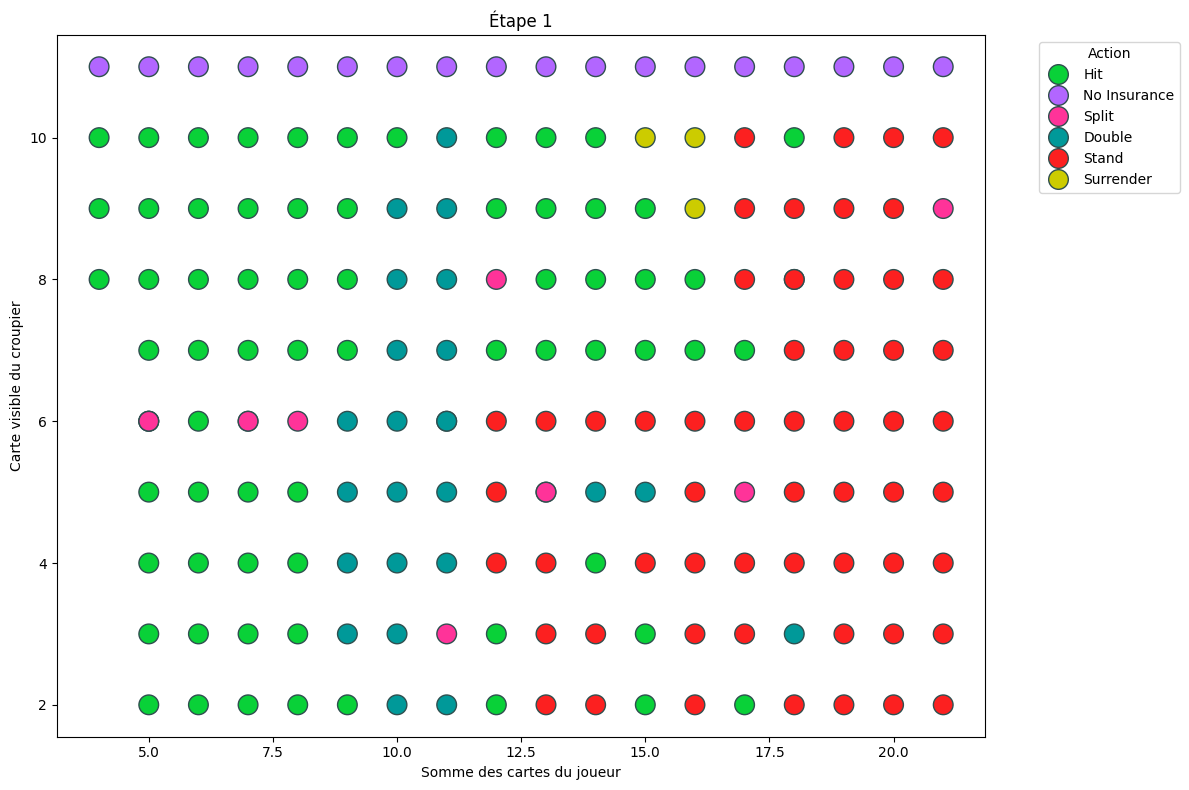

In [30]:
def step_graph_generator_sns(data, step):
    # Colonnes
    columns = ['dealer_up', 'win']
    hands = [f'player_card_{i}' for i in range(1, step + 2)]
    columns = columns + [f'action_taken_{step}'] + hands

    graphdata = data[columns].copy()
    graphdata['cards_sum'] = graphdata['player_card_1']
    for i in range(2, step + 2):
        graphdata.loc[:, 'cards_sum'] += graphdata.loc[:, f'player_card_{i}']

    hands_normalizer(graphdata, step + 1)

    # Filtre des données
    Graph = graphdata.query('win == 1')
    Graph['Counts'] = Graph.groupby(['cards_sum', 'dealer_up'])[
        f'action_taken_{step}'
    ].transform('count')
    MaxIndex = Graph.groupby(['cards_sum', 'dealer_up'])['Counts'].idxmax()
    FinalGraph = (
        Graph.loc[MaxIndex, :]
        .sort_values(['cards_sum', 'dealer_up'])
        .fillna('No Data')
    )

    FinalGraph = FinalGraph.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
    })

    # Choix des couleurs, le même pour tout les graphes par cohérence
    color_map = {
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0',
    }

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=FinalGraph,
        x='cards_sum',
        y='dealer_up',
        hue=f'action_taken_{step}',
        palette=color_map,
        s=200,
        edgecolor='darkslategrey',
        linewidth=1,
    )

    plt.title(f'Étape {step}')
    plt.xlabel("Somme des cartes du joueur")
    plt.ylabel("Carte visible du croupier")
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    return plt

# afficher une étape en particulier (1 par défaut)
step_graph_generator_sns(data, 1)
plt.show()

Cette fonction crée une visualisation détaillée des meilleures actions à prendre selon :
- La somme des cartes du joueur
- La carte visible du croupier
- L'étape du jeu en cours

Le graphique utilise un code couleur intuitif :
- Rouge (Stand) : Rester
- Vert (Hit) : Tirer une carte
- Bleu (Double) : Doubler la mise
- Rose (Split) : Séparer les cartes
- Jaune (Surrender) : Abandonner
- Violet (No Insurance) : Pas d'assurance

Cette visualisation nous permet d'identifier rapidement les stratégies optimales en fonction de la situation de jeu, basées sur les données réelles plutôt que sur des intuitions.

Pour compléter notre analyse, nous avons créé une deuxième visualisation qui montre la distribution complète des actions plutôt que seulement les actions optimales :

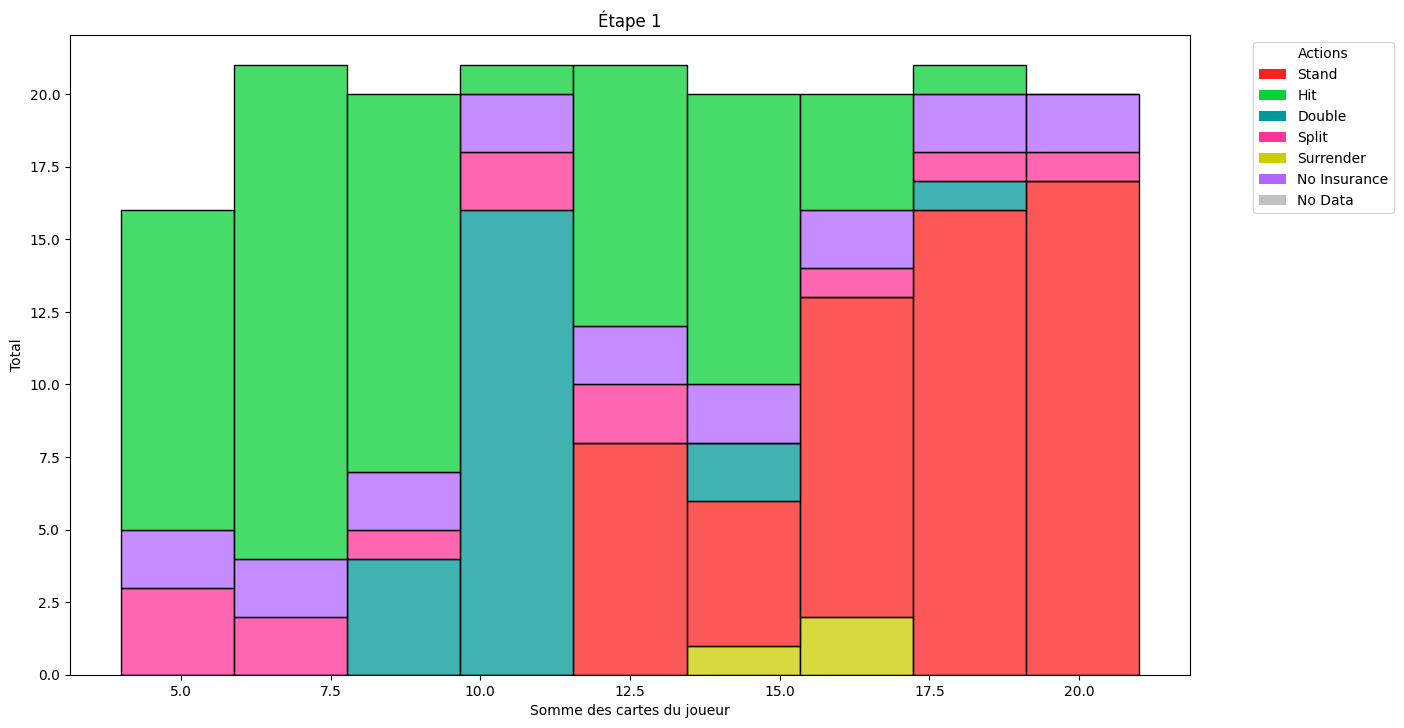

In [31]:
def step_bar_graph_generator_sns(data, step):
    columns = ['dealer_up', 'win']
    hands = [f'player_card_{i}' for i in range(1, step + 2)]
    columns = columns + [f'action_taken_{step}'] + hands

    graphdata = data[columns].copy()
    graphdata['cards_sum'] = graphdata['player_card_1']
    for i in range(2, step + 2):
        graphdata.loc[:, 'cards_sum'] += graphdata.loc[:, f'player_card_{i}']

    hands_normalizer(graphdata, step + 1)

    Graph = graphdata.query('win == 1')
    Graph['Counts'] = Graph.groupby(['cards_sum', 'dealer_up'])[
        f'action_taken_{step}'
    ].transform('count')
    MaxIndex = Graph.groupby(['cards_sum', 'dealer_up'])['Counts'].idxmax()
    FinalGraph = (
        Graph.loc[MaxIndex, :]
        .sort_values(['cards_sum', 'dealer_up'])
        .fillna('No Data')
    )

    FinalGraph = FinalGraph.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
    })

    color_map = {
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0',
    }

    plt.figure(figsize=(16, 8))

    ax = plt.axes([0.1, 0.1, 0.7, 0.8])

    sns.histplot(
        data=FinalGraph,
        x='cards_sum',
        hue=f'action_taken_{step}',
        palette=color_map,
        multiple="stack",
        ax=ax
    )

    plt.title(f'Étape {step}')
    plt.xlabel("Somme des cartes du joueur")
    plt.ylabel("Total")

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor=color, label=action)
        for action, color in color_map.items()
    ]

    ax.legend(
        handles=legend_elements,
        title='Actions',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    plt.tight_layout()

    return plt

# First step
step_bar_graph_generator_sns(data, 1)
plt.show()

Notre nouvelle fonction `step_bar_graph_generator_sns` crée un histogramme empilé qui montre :
- La distribution des actions pour chaque somme de cartes
- La fréquence relative de chaque action
- La répartition complète des décisions gagnantes

Le graphique utilise le même code couleur que précédemment.

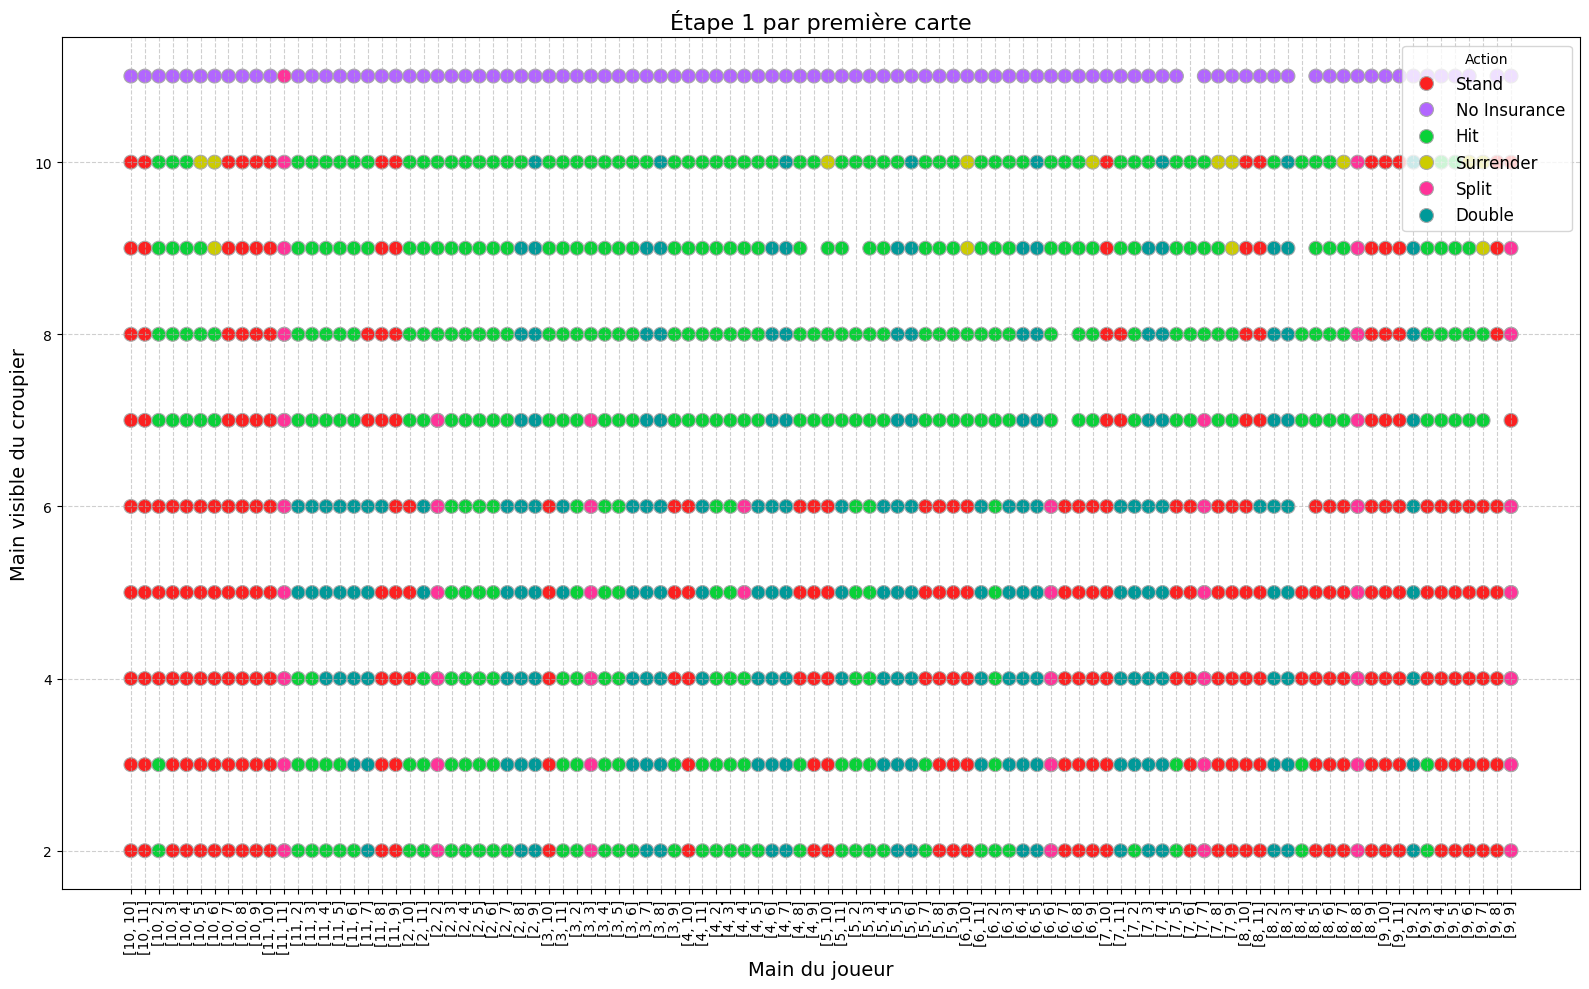

In [32]:
StepBy1stHand = data[['initial_hand', 'dealer_up', 'win', 'action_taken_1']]
StepBy1stHand['initial_hand'] = StepBy1stHand['initial_hand'].astype(str)
GraphD = StepBy1stHand.query('win == 1')
GraphD['Counts'] = GraphD.groupby(['initial_hand', 'dealer_up'])['action_taken_1'].transform('count')
MaxIndexD = GraphD.groupby(['initial_hand', 'dealer_up'])['Counts'].idxmax().drop_duplicates()
NewGraphD = GraphD.loc[MaxIndexD, :].sort_values(['initial_hand', 'dealer_up']).fillna('No Data')
NewGraphD = NewGraphD.replace({
    'S': 'Stand',
    'H': 'Hit',
    'D': 'Double',
    'P': 'Split',
    'R': 'Surrender',
    'N': 'No Insurance',
})

plt.figure(figsize=(16, 10))
scatterplot = sns.scatterplot(
    data=NewGraphD,
    x='initial_hand',
    y='dealer_up',
    hue='action_taken_1',
    palette={
        'Stand': '#FC2020',
        'Hit': '#09D138',
        'Double': "#009999",
        'Split': '#FF3399',
        'Surrender': "#CCCC00",
        'No Insurance': "#B266FF",
        'No Data': '#C0C0C0'
    },
    s=100,
    edgecolor='darkgrey'
)

scatterplot.set_title('Étape 1 par première carte', fontsize=16)
scatterplot.set_xlabel("Main du joueur", fontsize=14)
scatterplot.set_ylabel("Main visible du croupier", fontsize=14)
scatterplot.legend(title='Action', loc='upper right', fontsize=12)

# Rotation des labels de l'axe x
plt.xticks(rotation=90)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Ajuste automatiquement les marges pour éviter le chevauchement
plt.show()

Pour approfondir notre compréhension des stratégies gagnantes, nous avons créé une visualisation qui met en relation :
- La main initiale du joueur (2 premières cartes)
- La carte visible du croupier
- L'action recommandée menant le plus souvent à la victoire

Cette représentation sous forme de graphique à points nous permet d'identifier rapidement :
- Les situations où un split est recommandé (paires)
- Les mains fortes nécessitant de rester (stand)
- Les mains faibles nécessitant de tirer (hit)
- Les opportunités de doubler (double)

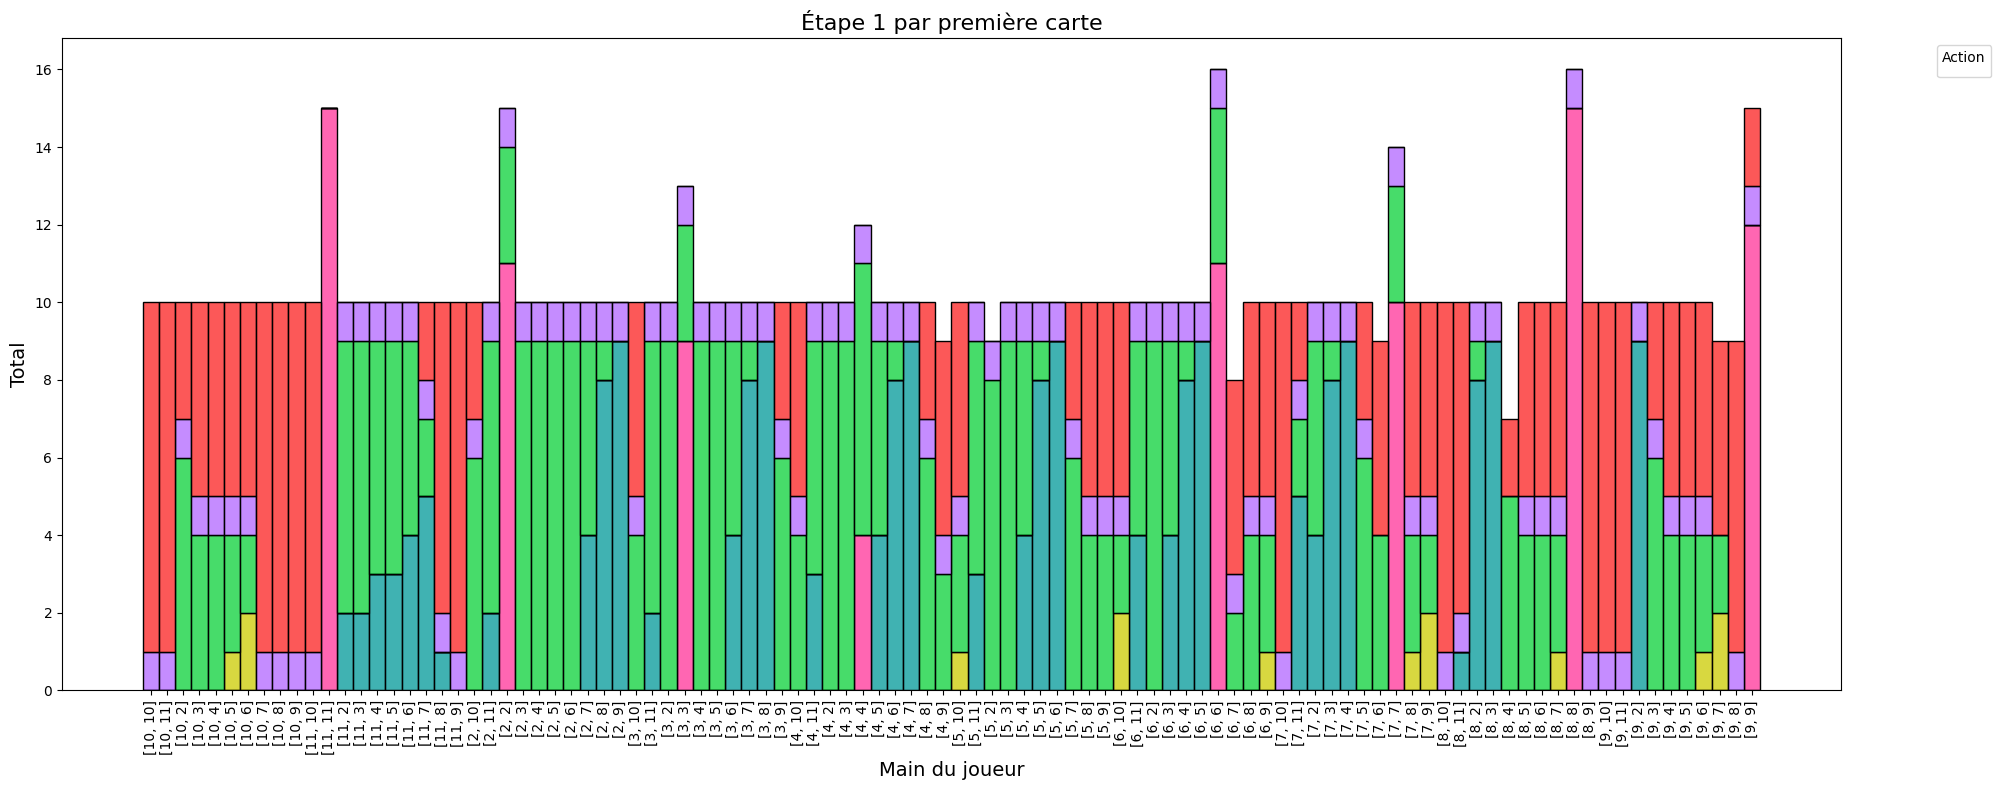

In [33]:
StepBy1stHand = data[['initial_hand', 'dealer_up', 'win', 'action_taken_1']]
StepBy1stHand['initial_hand'] = StepBy1stHand['initial_hand'].astype(str)
GraphD = StepBy1stHand.query('win == 1')
GraphD['Counts'] = GraphD.groupby(['initial_hand', 'dealer_up'])['action_taken_1'].transform('count')
MaxIndexD = GraphD.groupby(['initial_hand', 'dealer_up'])['Counts'].idxmax().drop_duplicates()
NewGraphD = GraphD.loc[MaxIndexD,:].sort_values(['initial_hand', 'dealer_up']).fillna('No Data')
NewGraphD = NewGraphD.replace({
    'S': 'Stand',
    'H': 'Hit',
    'D': 'Double',
    'P': 'Split',
    'R': 'Surrender',
    'N': 'No Insurance'
})

plt.figure(figsize=(20, 8))

color_map = {
    'Stand': '#FC2020',
    'Hit': '#09D138',
    'Double': "#009999",
    'Split': '#FF3399',
    'Surrender': "#CCCC00",
    'No Insurance': "#B266FF",
    'No Data': '#C0C0C0'
}

sns.histplot(
    data=NewGraphD,
    x='initial_hand',
    hue='action_taken_1',
    palette=color_map,
    multiple="stack"
)

plt.title('Étape 1 par première carte', fontsize=16)
plt.xlabel("Main du joueur", fontsize=14)
plt.ylabel("Total", fontsize=14)

plt.xticks(rotation=90)

plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

Pour compléter l'analyse précédente, nous avons créé un histogramme empilé qui montre :
- La fréquence des différentes actions pour chaque main initiale possible
- La distribution complète des décisions gagnantes
- Le nombre total d'occurrences de chaque combinaison

Ce graphique nous permet de mieux comprendre les situations où plusieurs actions peuvent être viables, ainsi que la prédominance de certaines décisions selon la main de départ.

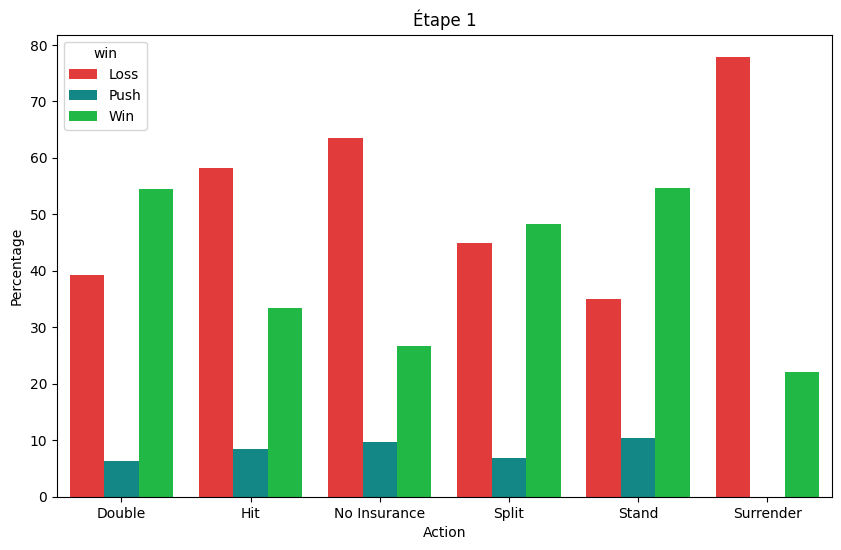

In [34]:
def win_by_action_graph_generator(data, step, norm):
    graphdata = data[[f'action_taken_{step}', 'win']]
    graphdata = graphdata.replace({
        'S': 'Stand',
        'H': 'Hit',
        'D': 'Double',
        'P': 'Split',
        'R': 'Surrender',
        'N': 'No Insurance',
        1: 'Win',
        0: 'Push',
        -1: 'Loss'
    })

    # Créer un groupby pour compter les occurrences
    grouped_data = graphdata.groupby([f'action_taken_{step}', 'win']).size().reset_index(name='count')

    plt.figure(figsize=(10, 6))
    if norm:
        total = grouped_data.groupby(f'action_taken_{step}')['count'].transform('sum')
        grouped_data['percentage'] = grouped_data['count'] / total * 100
        sns.barplot(
            data=grouped_data,
            x=f'action_taken_{step}',
            y='percentage',
            hue='win',
            palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'}
        )
        plt.ylabel('Percentage')
    else:
        sns.barplot(
            data=grouped_data,
            x=f'action_taken_{step}',
            y='count',
            hue='win',
            palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'}
        )
        plt.ylabel('Count')

    plt.title(f'Étape {step}')
    plt.xlabel('Action')
    plt.show()

win_by_action_graph_generator(data, 1, True)


Notre visualisation des résultats par type d'action révèle un pattern intéressant et contre-intuitif : l'action "Stand" (rester) montre généralement les meilleures chances de victoire, indépendamment de la main.

Le graphique montre pour chaque action possible :
- Le pourcentage de victoires (vert)
- Le pourcentage de défaites (rouge)
- Le pourcentage d'égalités (bleu)

Cette observation est particulièrement importante car elle :
- Remet en question certaines stratégies communes plus agressives
- Suggère une approche plus conservatrice dans le jeu
- Souligne l'importance de la patience dans la stratégie de jeu

Nous allons créer un nouveau graphique pour étayer cette hypothèse, en visualisant le taux moyen de victoires en fonction du nombre de cartes du joueur :

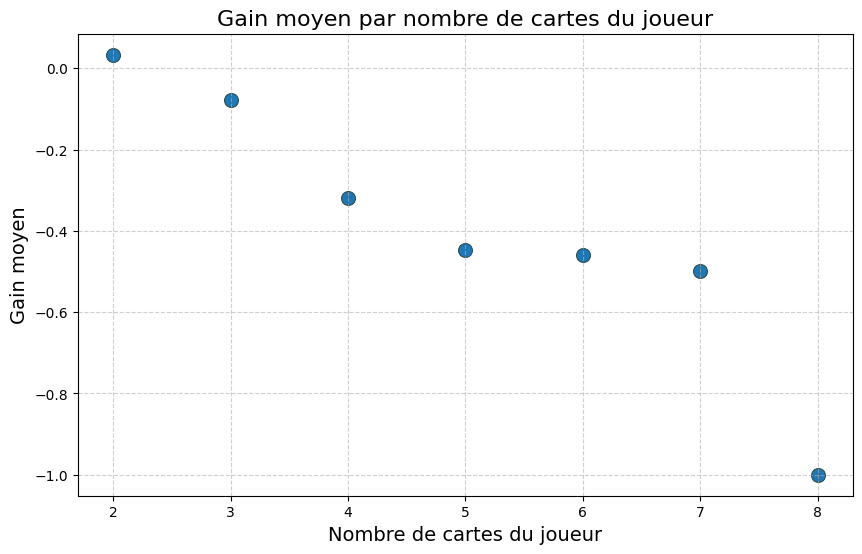

In [35]:
WinMean = pd.DataFrame(data['win'])
WinMean['len'] = data['player_final'].apply(lambda x: len(x))
WinMeanPlotData = pd.DataFrame(WinMean.groupby(['len'])['win'].mean()).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=WinMeanPlotData, x='len', y='win', s=100, edgecolor='darkslategrey')

plt.xlabel("Nombre de cartes du joueur", fontsize=14)
plt.ylabel("Gain moyen", fontsize=14)
plt.title("Gain moyen par nombre de cartes du joueur", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Cette analyse confirme notre hypothèse précédente. Le graphique montre une diminution constante des chances de victoire avec l'augmentation du nombre de cartes.

Point crucial : avec seulement 2 cartes (stand immédiat après la distribution initiale), la moyenne de gain est **positive**, ce qui renforce notre observation sur l'efficacité de la stratégie conservatrice.

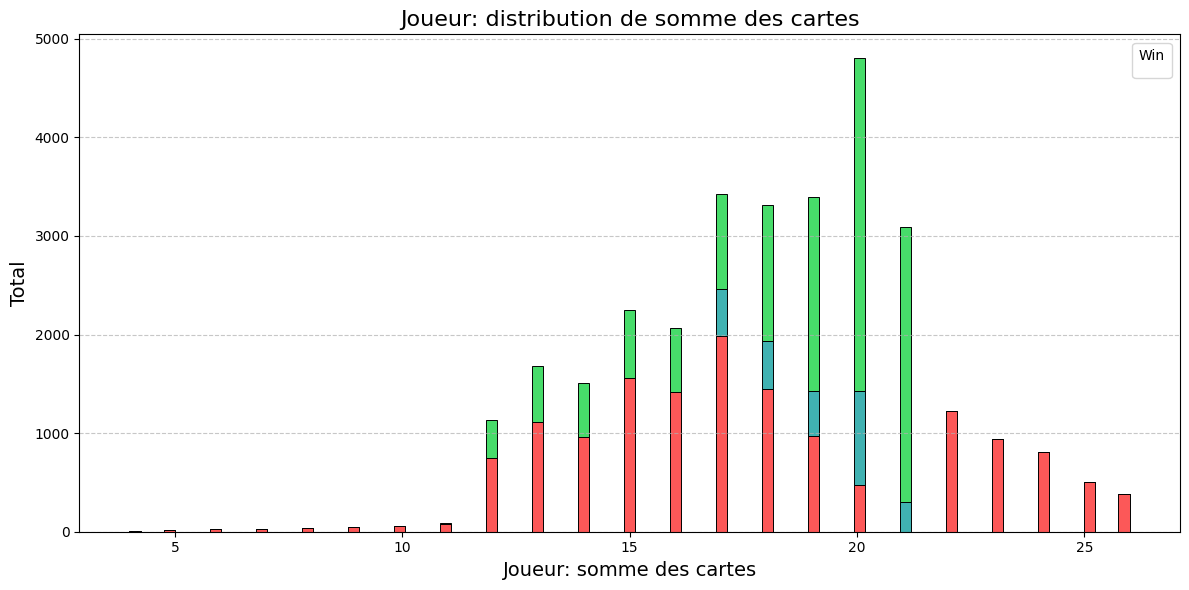

In [36]:
def win_total_graph_generator(data, selection):
    if selection == 'croupier':
        graphdata = data[['dealer_final_value', 'win']].replace({-1: 'Win', 0: 'Push', 1: 'Loss'})
        value_column = 'dealer_final_value'
    elif selection == 'joueur':
        graphdata = data[['player_final_value', 'win']].replace({1: 'Win', 0: 'Push', -1: 'Loss'})
        value_column = 'player_final_value'

    plt.figure(figsize=(12, 6))
    sns.histplot(data=graphdata, x=value_column, hue='win', multiple='stack', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': '#009999'})

    plt.title(f"{selection.title()}: distribution de somme des cartes", fontsize=16)
    plt.xlabel(f"{selection.title()}: somme des cartes", fontsize=14)
    plt.ylabel('Total', fontsize=14)
    plt.legend(title='Win', fontsize=12, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

win_total_graph_generator(data, 'joueur')



L'analyse de la distribution des résultats révèle des patterns logiques :

- Pour une somme de 21 :
  - Uniquement des victoires ou des égalités
  - Aucune défaite possible

- Pour une somme supérieure à 21 :
  - 100% de défaites (zone rouge)
  - Confirme la règle du "bust"

Ces observations confirment la cohérence de nos données avec les règles du Blackjack et valident la qualité de notre jeu de données pour l'entraînement de notre modèle.

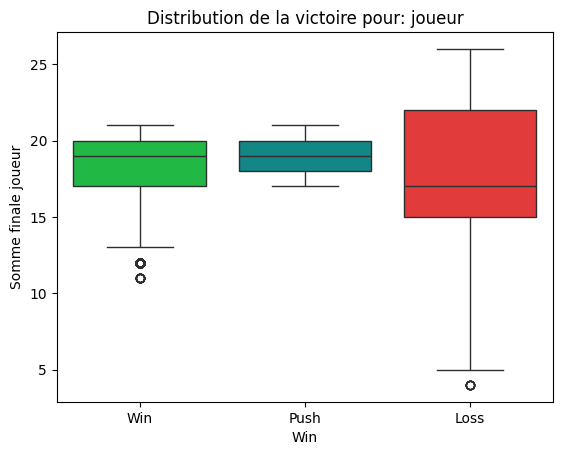

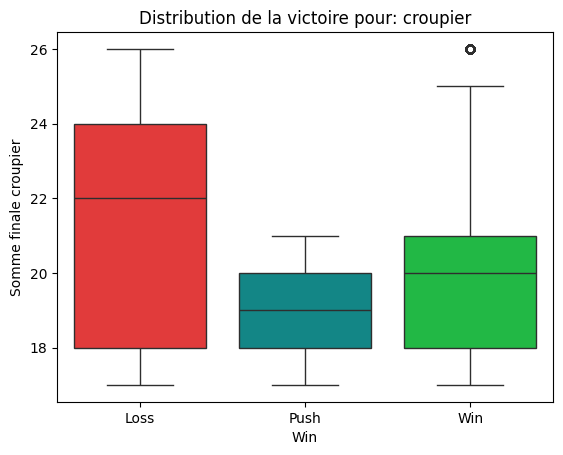

In [37]:
def win_box_plot_generator_seaborn(data, side):
    if side == 'croupier':
        plot_data = data.replace({1: 'Loss', 0: 'Push', -1: 'Win'})
        sns.boxplot(data=plot_data, x='win', y='dealer_final_value', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': "#009999"})
        plt.title(f'Distribution de la victoire pour: {side}')
        plt.xlabel("Win")
        plt.ylabel("Somme finale croupier")
        plt.show()
    elif side == 'joueur':
        plot_data = data.replace({1: 'Win', 0: 'Push', -1: 'Loss'})
        sns.boxplot(data=plot_data, x='win', y='player_final_value', palette={'Loss': '#FC2020', 'Win': '#09D138', 'Push': "#009999"})
        plt.title(f'Distribution de la victoire pour: {side}')
        plt.xlabel("Win")
        plt.ylabel("Somme finale joueur")
        plt.show()

def show_win_box_plot_seaborn(side='player'):
    win_box_plot_generator_seaborn(data, side)


show_win_box_plot_seaborn(side='joueur')
show_win_box_plot_seaborn(side='croupier')

L'analyse de la distribution totale révèle des comportements intéressants :

### Pour le Dealer
- Le minimum de cartes est toujours 17 (règle du jeu)
- Des victoires apparentes avec plus de 21 points s'expliquent : le dealer gagne automatiquement si le joueur a "bust" avant lui

### Pour le Joueur
- Distribution plus large des sommes possibles
- Zone verte (victoires) principalement concentrée entre 17 et 21
- Au-delà de 21, uniquement des défaites

Note importante : Dans ces graphiques, la "victoire" est relative au point de vue analysé (dealer ou joueur).

# Modélisation


On va maintenant passer à la création du model pour essayer de prédire les résultats d'une main. On va d'abord préparer nos données.

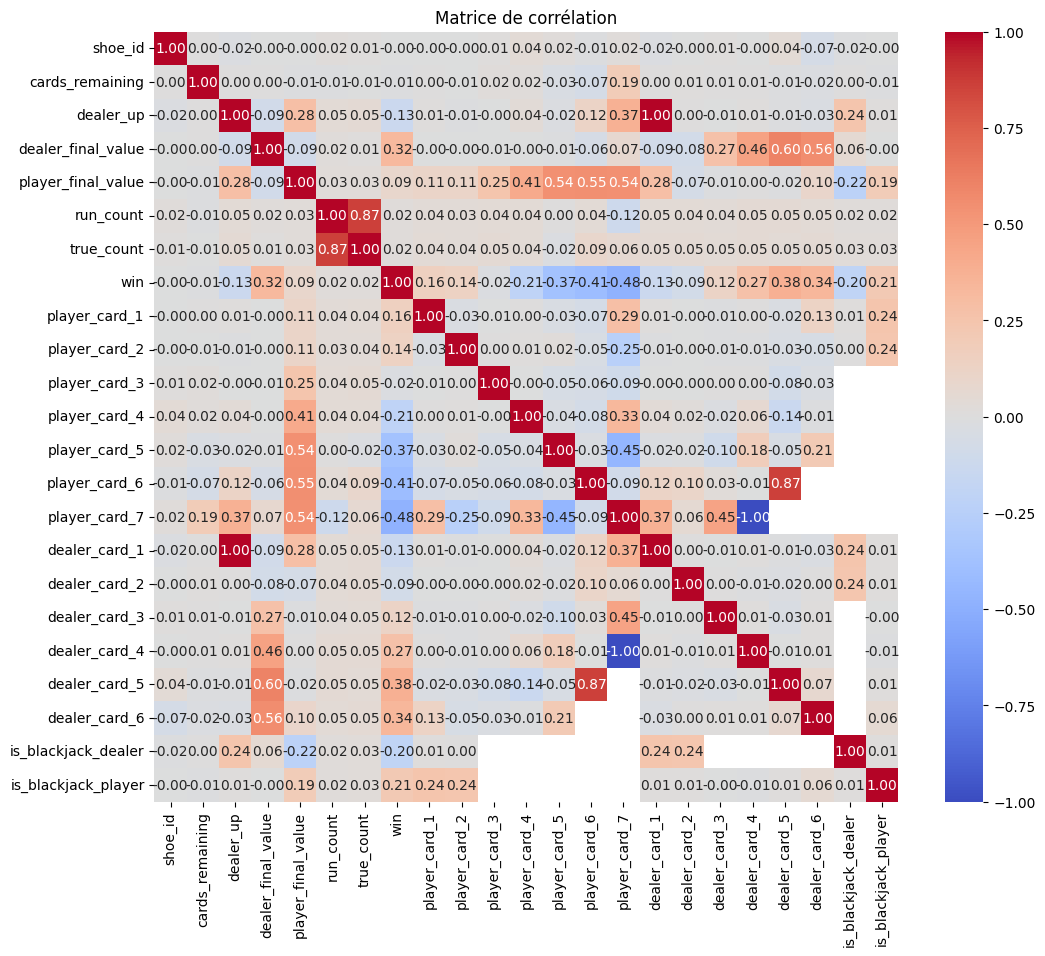

In [38]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

corrmatx = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corrmatx, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation")
plt.show()

L'analyse de la matrice de corrélation des données numériques révèle une absence de corrélations significatives entre nos variables. Ce constat est important car :

- Il suggère que nos variables sont indépendantes
- Il évite les problèmes de multicolinéarité
- Il indique que chaque variable peut potentiellement apporter une information unique à notre modèle

Cette absence de corrélation forte entre les variables est un bon signe pour la construction de notre modèle prédictif, car cela signifie que chaque feature pourrait contribuer de manière distincte à la prédiction.

On commence par le préprocess des données :

In [39]:
prepdata = data.sample(n=30838)

Pour évaluer nos modèles, nous préparons :
- X : données d'entrée (features) sans la colonne 'win'
- y : variable cible (résultats des parties)
- Validation croisée stratifiée à 5 plis pour garantir une distribution équilibrée des classes dans chaque fold

In [40]:
# Use the preprocessed data we have
X = prepdata.drop('win', axis=1)
y = prepdata['win']

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [41]:
print("Baseline Performance:")
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_scores = cross_val_score(dummy_clf, X, y, cv=cv, scoring='accuracy')
print(f"DummyClassifier accuracy: {dummy_scores.mean():0.3f} (+/- {dummy_scores.std() * 2:0.3f})")

Baseline Performance:
DummyClassifier accuracy: 0.481 (+/- 0.000)


Le modèle de référence (DummyClassifier) atteint une précision de 48% en prédisant systématiquement la classe majoritaire. Cette performance servira de base de comparaison pour nos modèles plus sophistiqués.

In [42]:
prepdata.drop(['dealer_up','initial_hand','dealer_final','dealer_final_value','player_final','player_final_value','actions_taken'],axis=1,inplace=True)  # Duplicate data
prepdata.drop(['shoe_id'],axis=1,inplace=True) # Comme dit au début, on ignore le talon

Dans le cadre de la préparation des données, nous avons supprimé :

1. Les données redondantes :
- dealer_up (carte visible du dealer)
- initial_hand (main initiale)
- dealer_final/player_final (mains finales)
- dealer_final_value/player_final_value (valeurs finales)
- actions_taken (actions effectuées)

2. Les données non pertinentes :
- shoe_id (identifiant du sabot)

Cette simplification permet d'éviter la redondance d'information et de se concentrer sur les variables vraiment prédictives.

In [43]:
prepdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 18157 to 3258
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cards_remaining      30838 non-null  int64  
 1   run_count            30838 non-null  int64  
 2   true_count           30838 non-null  int64  
 3   win                  30838 non-null  int64  
 4   player_card_1        30838 non-null  int64  
 5   player_card_2        30838 non-null  int64  
 6   player_card_3        13758 non-null  float64
 7   player_card_4        3684 non-null   float64
 8   player_card_5        712 non-null    float64
 9   player_card_6        98 non-null     float64
 10  player_card_7        11 non-null     float64
 11  dealer_card_1        30838 non-null  int64  
 12  dealer_card_2        30838 non-null  int64  
 13  dealer_card_3        20597 non-null  float64
 14  dealer_card_4        6850 non-null   float64
 15  dealer_card_5        1376 non-null   f

Pour la préparation finale des données :
- Remplacement des NaN par -1 dans les colonnes de cartes
- Conversion des types float en int pour compatibilité avec KNN

In [44]:
prepdata[['action_taken_1','action_taken_2','action_taken_3','action_taken_4','action_taken_5','action_taken_6']] = prepdata[['action_taken_1','action_taken_2','action_taken_3','action_taken_4','action_taken_5','action_taken_6']].replace({ 'S' : 1, 'H' : 2 , 'D' : 3 , 'P' : 4 , 'R' : 5 , 'N' : 6})

In [45]:
prepdata = prepdata.fillna(0).astype('int')
prepdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30838 entries, 18157 to 3258
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   cards_remaining      30838 non-null  int64
 1   run_count            30838 non-null  int64
 2   true_count           30838 non-null  int64
 3   win                  30838 non-null  int64
 4   player_card_1        30838 non-null  int64
 5   player_card_2        30838 non-null  int64
 6   player_card_3        30838 non-null  int64
 7   player_card_4        30838 non-null  int64
 8   player_card_5        30838 non-null  int64
 9   player_card_6        30838 non-null  int64
 10  player_card_7        30838 non-null  int64
 11  dealer_card_1        30838 non-null  int64
 12  dealer_card_2        30838 non-null  int64
 13  dealer_card_3        30838 non-null  int64
 14  dealer_card_4        30838 non-null  int64
 15  dealer_card_5        30838 non-null  int64
 16  dealer_card_6        308

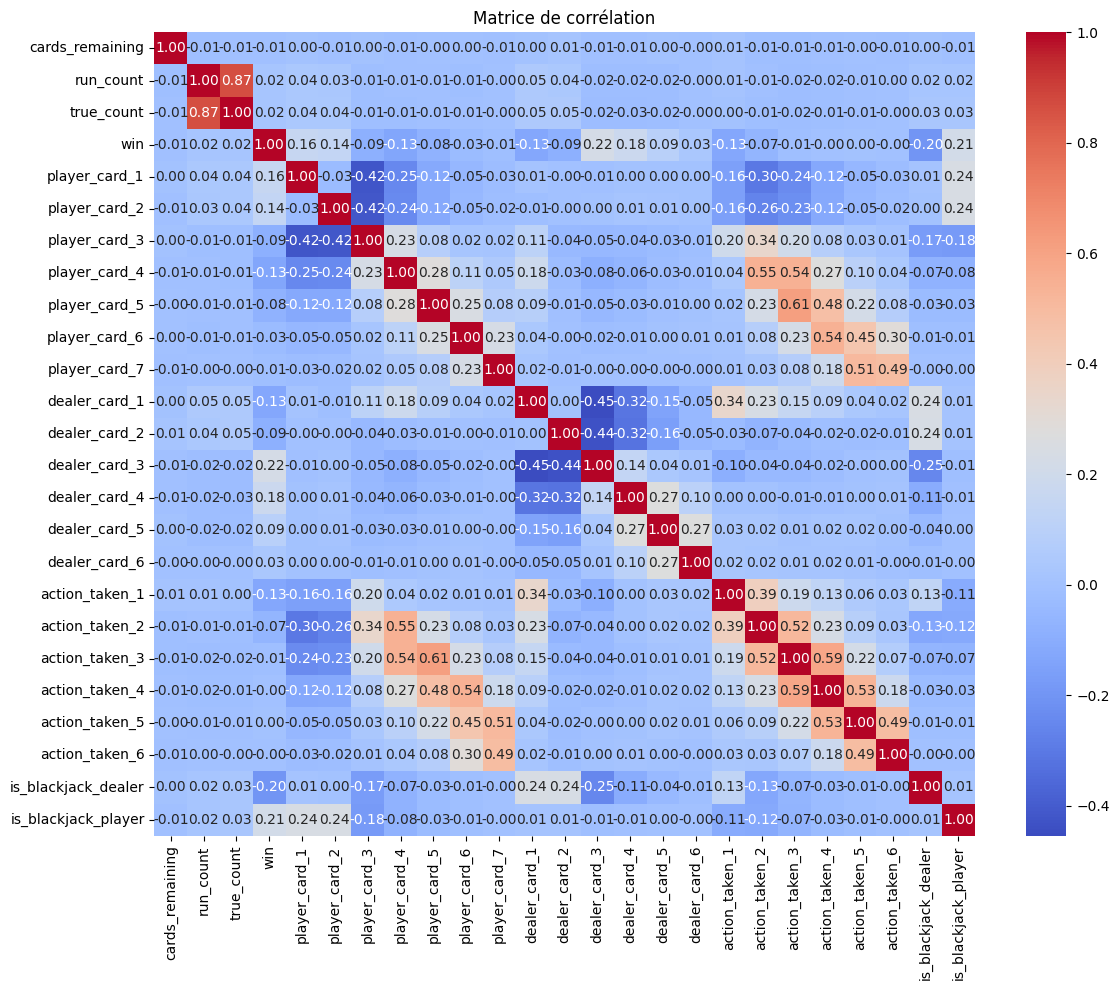

In [46]:
plt.figure(figsize=(12, 10))
sns.heatmap(prepdata.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

In [47]:
prepdata['win'].value_counts()

win
-1    14826
 1    13345
 0     2667
Name: count, dtype: int64

Après le nettoyage final des données, deux observations importantes :

1. La matrice de corrélation montre toujours peu de corrélations entre les variables, confirmant la pertinence de nos features. (Même si on observe des légères corrélations entre les actions et le nombre de cartes)

2. La distribution des classes reste déséquilibrée, avec des proportions similaires aux données d'origine :
- Pertes : ~48%
- Victoires : ~44%
- Égalités : ~8%

Ce déséquilibre devra être pris en compte dans la sélection et le paramétrage de nos modèles. Notre objectif est de maximiser la précision pour minimiser les fausses prédictions positives.

## KNN

Nous commençons avec l'algorithme des k plus proches voisins (KNN) pour plusieurs raisons :
- Sa simplicité d'implémentation et d'interprétation
- Sa bonne gestion naturelle des données déséquilibrées
- Sa flexibilité via l'hyperparamètre k

Pour optimiser les performances, nous testons différentes valeurs de k afin d'identifier la configuration optimale.

In [48]:
KNNlist = [x for x in range(1,26,2)]
acclist = []
perlist = []
conflist = {}
x_train,x_test,y_train,y_test= train_test_split(prepdata.drop('win',axis=1),prepdata['win'], test_size=0.2)
for k in KNNlist:
    knnfittype = KNeighborsClassifier(n_neighbors=k)
    knnfittype.fit(x_train,y_train)
    y_pred = knnfittype.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    percision =  metrics.precision_score(y_test,y_pred,average='weighted')
    confmatx = pd.DataFrame({'True':y_test, 'Predicted': y_pred}).groupby(['True','Predicted']).size()
    acclist.append(accuracy)
    perlist.append(percision)
    conflist[k] = confmatx
totalscore = pd.DataFrame({'Exactitude' : acclist , 'Precision' : perlist} , index = KNNlist)
totalscore

,Exactitude,Precision
1,0.593547,0.591778
3,0.606193,0.581761
5,0.614462,0.594989
7,0.621920,0.597826
9,0.624514,0.597201
11,0.625000,0.601559
13,0.629215,0.603847
15,0.626459,0.607596
17,0.625162,0.602571
19,0.625000,0.601066


In [49]:
def prepare_data_for_knn(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    X = df[numeric_cols]

    X = X.fillna(0)

    return X

# Cross-Validation de KNN
def evaluate_knn(k_values, X, y, cv=5):
    results = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv, scoring='f1_weighted')
        print(f"KNN k={k}: F1 = {scores.mean():0.3f} (+/- {scores.std() * 2:0.3f})")
        results.append({
            'k': k,
            'f1_mean': scores.mean(),
            'f1_std': scores.std()
        })
    return pd.DataFrame(results)

X = prepare_data_for_knn(prepdata) # (on ne peut pas cv avec des list, des str, ...)
print("KNN Performance:")
knn_results = evaluate_knn(KNNlist, X, y)

KNN Performance:
KNN k=1: F1 = 0.659 (+/- 0.002)
KNN k=3: F1 = 0.668 (+/- 0.007)
KNN k=5: F1 = 0.675 (+/- 0.015)
KNN k=7: F1 = 0.672 (+/- 0.010)
KNN k=9: F1 = 0.674 (+/- 0.008)
KNN k=11: F1 = 0.671 (+/- 0.008)
KNN k=13: F1 = 0.670 (+/- 0.006)
KNN k=15: F1 = 0.668 (+/- 0.009)
KNN k=17: F1 = 0.669 (+/- 0.005)
KNN k=19: F1 = 0.667 (+/- 0.008)
KNN k=21: F1 = 0.666 (+/- 0.007)
KNN k=23: F1 = 0.665 (+/- 0.008)
KNN k=25: F1 = 0.664 (+/- 0.009)


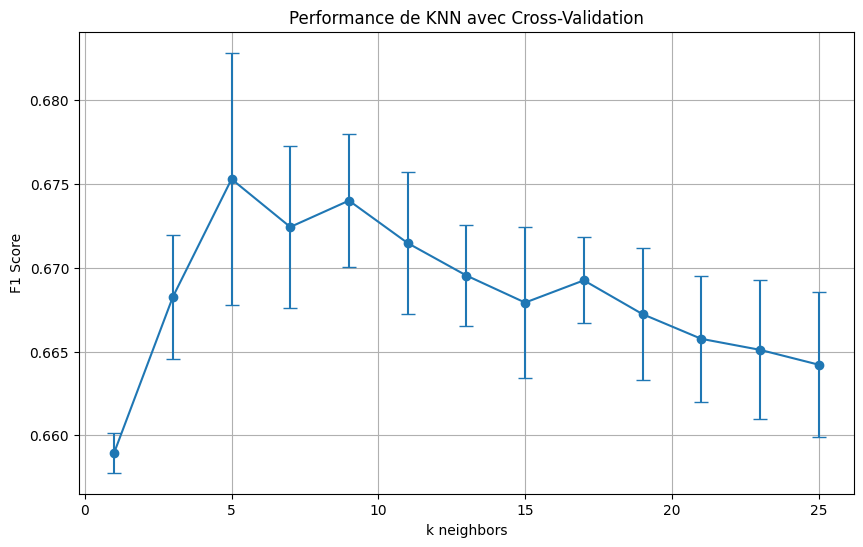

In [50]:
plt.figure(figsize=(10, 6))
plt.errorbar(knn_results['k'], knn_results['f1_mean'], yerr=knn_results['f1_std'], fmt='o-', capsize=5)
plt.xlabel('k neighbors')
plt.ylabel('F1 Score')
plt.title('Performance de KNN avec Cross-Validation')
plt.grid(True)
plt.show()

Résultats du test avec différentes valeurs de k (1 à 26) :

1. Performance limitée :
- Précision et exactitude faibles pour toutes les valeurs de k
- Difficulté particulière à prédire les égalités (Push)

2. Limitations identifiées :
- Dimensionnalité élevée (24 colonnes)
- Instabilité des résultats selon l'échantillon choisi
- La valeur optimale de k varie selon les runs

La cross-validation confirme ces performances modestes, suggérant que KNN n'est pas le meilleur choix pour ce problème spécifique.

## Random Forest


Nous allons passer et tester Random Forest pour :
- Son efficacité sur les données discrètes à faible amplitude
- Sa simplicité d'implémentation

In [51]:
x_train,x_test,y_train,y_test= train_test_split(prepdata.drop('win',axis=1),prepdata['win'],test_size=0.2)
rffittype = RandomForestClassifier(class_weight= 'balanced')
rffittype.fit(x_train,y_train)
y_pred = rffittype.predict(x_test)
print(classification_report(y_test, y_pred , digits = 3))

              precision    recall  f1-score   support

          -1      0.874     0.905     0.889      2928
           0      0.823     0.286     0.425       552
           1      0.835     0.914     0.872      2688

    accuracy                          0.854      6168
   macro avg      0.844     0.702     0.729      6168
weighted avg      0.852     0.854     0.840      6168



In [52]:
print("Performance de Random Forest:")
rf_scores = cross_val_score(rffittype, prepdata.drop('win', axis=1), prepdata['win'],
                        cv=cv, scoring='f1_weighted')
print(f"F1: {rf_scores.mean():0.3f} (+/- {rf_scores.std():0.3f})")

Performance de Random Forest:
F1: 0.836 (+/- 0.005)


Performance globale :
- Précision : ~84%
- Score F1 : ~83%

Analyse détaillée par classe :
- Défaites (-1) : Précision 87.7%, Recall 90.2%
- Égalités (0) : Précision 75.5%, Recall 31.8%
- Victoires (1) : Précision 82.8%, Recall 89.8%

Le Random Forest montre des performances nettement supérieures au KNN, probablement grâce à sa bonne adaptation aux données discrètes de notre jeu. Notons cependant une difficulté persistante à prédire les égalités, comme en témoigne leur faible recall.

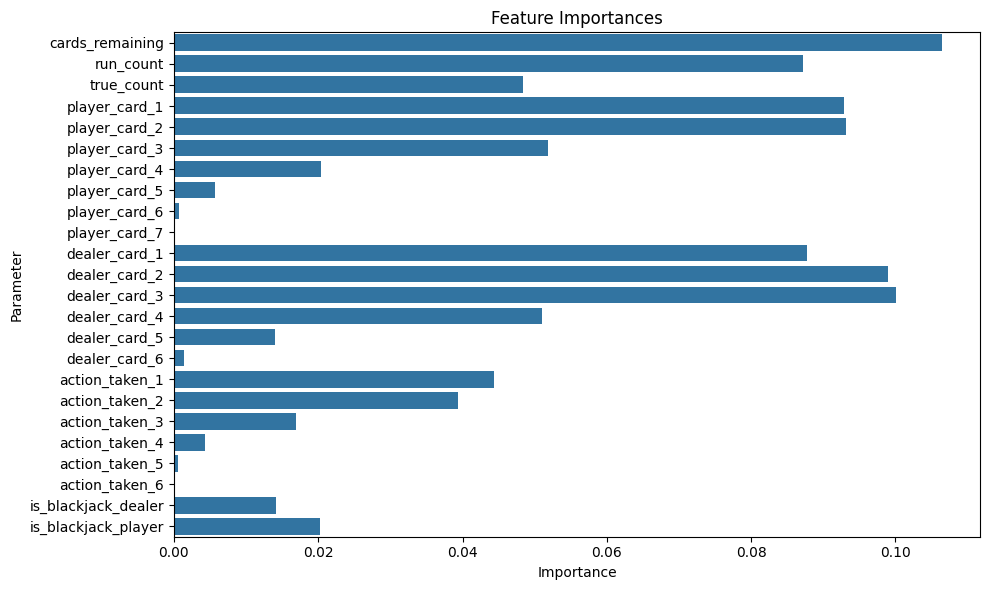

In [53]:
importance = rffittype.feature_importances_
params = prepdata.drop('win', axis=1).columns
importancetable = pd.DataFrame({'Parameter': params, 'Importance': importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Parameter', data=importancetable, orient='h')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Parameter')
plt.tight_layout()
plt.show()

L'analyse des importances des features révèle :

1. Features les moins importantes :
- Cartes tirées tardivement
- Actions après plusieurs tours

2. Contribution équilibrée :
La majorité des autres paramètres ont une importance similaire

Malgré leur faible importance, nous conservons toutes les features car elles représentent des aspects essentiels d'une main de Blackjack et leur suppression risquerait de perdre des informations contextuelles importantes.

## Gradient Boosting

Le Gradient Boosting présente des avantages clés :
- Performance généralement supérieure au Random Forest
- Meilleure gestion du surapprentissage

Point d'attention : La gestion des données déséquilibrées nécessite une approche spécifique dès la séparation train/test, contrairement au Random Forest qui propose une solution intégrée.

In [54]:
x_train,x_test,y_train,y_test= train_test_split(prepdata.drop('win',axis=1),prepdata['win'],test_size=0.2)
gbfittype = GradientBoostingClassifier()
gbfittype.fit(x_train,y_train)
y_pred = gbfittype.predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))

              precision    recall  f1-score   support

          -1      0.807     0.869     0.837      2948
           0      0.825     0.152     0.256       561
           1      0.788     0.857     0.821      2659

    accuracy                          0.798      6168
   macro avg      0.807     0.626     0.638      6168
weighted avg      0.800     0.798     0.777      6168



In [55]:
pd.DataFrame({'True':y_test, 'Predicted': y_pred}).groupby(['True','Predicted']).size()

True  Predicted
-1    -1           2561
       0             14
       1            373
 0    -1            236
       0             85
       1            240
 1    -1            377
       0              4
       1           2278
dtype: int64

In [56]:
print("Performance de Gradient Boosting:")
gb_scores = cross_val_score(gbfittype, prepdata.drop('win',axis=1), prepdata['win'],
                        cv=cv, scoring='f1_weighted')
print(f"F1: {gb_scores.mean():0.3f} (+/- {gb_scores.std() * 2:0.3f})")

Performance de Gradient Boosting:
F1: 0.769 (+/- 0.015)


Résultats :
- Précision globale : ~80%
- Score F1 : 0.772

Analyse détaillée :
- Performance inférieure au Random Forest
- Difficulté majeure avec les égalités :
 - Seulement 14.3% des égalités correctement identifiées
 - Confusion fréquente avec victoires et défaites

Contrairement à nos attentes, le Gradient Boosting n'a pas surpassé le Random Forest sur notre jeu de données.

## Régression Logistique

Notre dernier choix de modèle se porte sur la régression logistique :
- Adaptée intuitivement aux situations binaires (victoire/défaite)
- Configuration en "One vs. Rest" pour gérer la classe supplémentaire (égalité)

In [57]:
x_train,x_test,y_train,y_test= train_test_split(prepdata.drop('win',axis=1),prepdata['win'],test_size=0.2)
logfittype = LogisticRegression(multi_class='ovr', solver='liblinear' , class_weight= 'balanced')
logfittype.fit(x_train,y_train)
y_pred = logfittype.predict(x_test)
print(classification_report(y_test, y_pred, digits = 3))
accuracy = metrics.accuracy_score(y_test,y_pred)
percision =  metrics.precision_score(y_test,y_pred,average='weighted')
pd.DataFrame({'True':y_test, 'Predicted': y_pred}).groupby(['True','Predicted']).size()

              precision    recall  f1-score   support

          -1      0.700     0.668     0.684      2982
           0      0.231     0.344     0.276       540
           1      0.651     0.620     0.635      2646

    accuracy                          0.619      6168
   macro avg      0.528     0.544     0.532      6168
weighted avg      0.638     0.619     0.627      6168



True  Predicted
-1    -1           1992
       0            259
       1            731
 0    -1            207
       0            186
       1            147
 1    -1            645
       0            361
       1           1640
dtype: int64

In [58]:
print("Performance de la Régression Logistique:")
log_scores = cross_val_score(logfittype, prepdata.drop('win', axis=1), prepdata['win'], cv=cv, scoring='f1_weighted')
print(f"F1: {log_scores.mean():0.3f} (+/- {log_scores.std() * 2:0.3f})")

Performance de la Régression Logistique:
F1: 0.625 (+/- 0.013)


Performance globale :
- Précision : 64%
- Score F1 : 63%

Malgré notre intuition initiale, la régression logistique montre des performances décevantes :
- Difficultés avec les égalités (précision 25.2%)
- Taux de prédiction correct faible pour toutes les classes
- Performances inférieures aux modèles basés sur les arbres

Cette sous-performance s'explique probablement par l'absence de fortes corrélations linéaires entre nos variables, rendant le modèle moins adapté à notre cas d'usage.

## Cross-validation

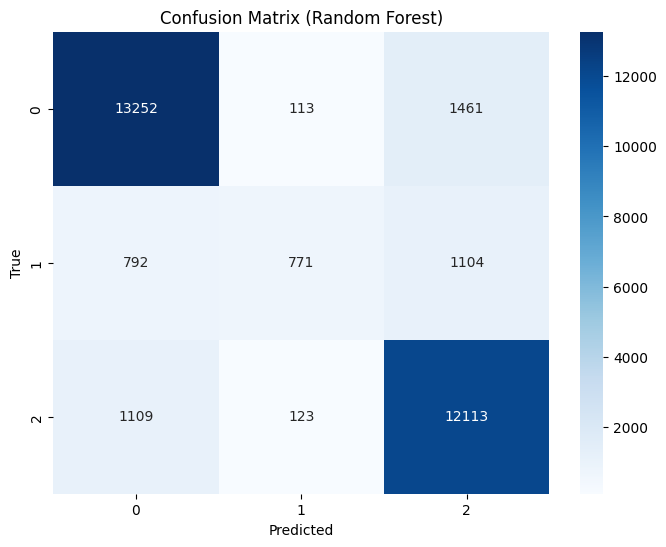

              precision    recall  f1-score   support

          -1      0.875     0.894     0.884     14826
           0      0.766     0.289     0.420      2667
           1      0.825     0.908     0.865     13345

    accuracy                          0.848     30838
   macro avg      0.822     0.697     0.723     30838
weighted avg      0.844     0.848     0.835     30838



In [59]:
rf_predictions = cross_val_predict(rffittype, prepdata.drop('win', axis=1), prepdata['win'], cv=cv)

conf_matrix = confusion_matrix(y, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y, rf_predictions, digits=3))

La validation croisée confirme les performances du Random Forest :

Performance globale :
- Exactitude : 84.7%
- Score F1 : 83.5%

Détail par classe :
- Défaites : 88.4% F1-score
- Victoires : 86.2% F1-score
- Égalités : 42.6% F1-score

La matrice de confusion montre la persistance d'une difficulté à identifier les égalités, mais confirme la robustesse du modèle pour la prédiction des victoires et défaites.

## Optimisation des hyper-paramètres

### Préparation des données pour l'optimisation

La première étape consiste à séparer correctement nos données en ensembles d'entraînement et de test. L'utilisation de stratify=y est cruciale ici car nos classes sont déséquilibrées. Cela garantit que la distribution des classes reste similaire dans les deux ensembles.

In [78]:
X = prepdata.drop('win', axis=1)
y = prepdata['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

### Fonction d'évaluation

La fonction evaluate_model est utile pour fournir une évaluation complète des modèles. Elle calcule à la fois les scores sur l'ensemble d'entraînement et de test, ce qui permet de détecter le surapprentissage. Les métriques choisies (accuracy et F1) sont particulièrement pertinentes pour notre cas de classification déséquilibrée.

In [81]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Scores
    scores = {
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'train_f1': f1_score(y_train, y_pred_train, average='weighted'),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'test_f1': f1_score(y_test, y_pred_test, average='weighted')
    }
    
    return scores, y_pred_test

### Random Forest

Nous avons plusieurs paramètres qui influent sur Random Forest. Nous allons donc les lister et utiliser une fonction qui testera les différentes combinaisons pour trouver la meilleure.

L'optimisation du Random Forest se concentre sur quatre paramètres clés :

- n_estimators : nombre d'arbres (100-300)
- max_depth : profondeur maximale des arbres
- min_samples_split : nombre minimum d'échantillons pour diviser un nœud
- max_features : nombre de features à considérer pour chaque split

In [96]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_search = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

rf_search.fit(X_train, y_train)

print("Meilleurs paramètres RF:", rf_search.best_params_)
print("Meilleur score RF:", rf_search.best_score_)

rf_scores, rf_predictions = evaluate_model(rf_search.best_estimator_, 
                                         X_train, X_test, y_train, y_test)

Meilleurs paramètres RF: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Meilleur score RF: 0.8189678711886208


Les résultats montrent une performance optimale avec une profondeur non limitée et 200 arbres, suggérant que le modèle bénéficie d'une complexité élevée. Le score F1 de 0.82 est prometteur mais pourrait indiquer un léger surapprentissage.

### Gradient Boosting

Les paramètres optimisés incluent :

- learning_rate : taux d'apprentissage
- max_depth : profondeur des arbres
- subsample : fraction d'échantillons pour chaque arbre

In [90]:
param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.1, 0.05, 0.02],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__subsample': [0.8, 1.0]
}

gb_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_search = GridSearchCV(
    gb_pipeline,
    param_grid_gb,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

gb_search.fit(X_train, y_train)

print("Meilleurs paramètres GB:", gb_search.best_params_)
print("Meilleur score GB:", gb_search.best_score_)

gb_scores, gb_predictions = evaluate_model(gb_search.best_estimator_, 
                                         X_train, X_test, y_train, y_test)

Meilleurs paramètres GB: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
Meilleur score GB: 0.8518565941089775


Le score F1 de 0.85 est le meilleur obtenu, avec des paramètres suggérant un modèle assez agressif (learning_rate=0.1, max_depth=7). Cette configuration pourrait être risquée en termes de généralisation.

### KNN

L'optimisation de KNN est plus simple, se concentrant sur :

- n_neighbors : nombre de voisins
- weights : pondération des voisins
- p : métrique de distance

In [ ]:
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

knn_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

knn_search = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

knn_search.fit(X_train, y_train)

print("Meilleurs paramètres KNN:", knn_search.best_params_)
print("Meilleur score KNN:", knn_search.best_score_)

knn_scores, knn_predictions = evaluate_model(knn_search.best_estimator_, 
                                           X_train, X_test, y_train, y_test)

Meilleurs paramètres KNN: {'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}
Meilleur score KNN: 0.5905773536055026


La performance médiocre (F1=0.59) confirme que KNN n'est pas adapté à ce problème, probablement à cause de la haute dimensionnalité des données.

### Régression Logistique

Les paramètres clés sont :

- C : inverse de la régularisation
- penalty : type de régularisation
- max_iter : nombre maximum d'itérations

In [93]:
param_grid_log = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [1000, 2000, 3000],
    'classifier__solver': ['liblinear']  # Nécessaire pour supporter l1 et l2
}

log_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(multi_class='ovr', 
                                    class_weight='balanced',
                                    random_state=42))
])

log_search = GridSearchCV(
    log_pipeline,
    param_grid_log,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    return_train_score=True
)

log_search.fit(X_train, y_train)

print("Meilleurs paramètres Régression Logistique:", log_search.best_params_)
print("Meilleur score:", log_search.best_score_)

log_scores, log_predictions = evaluate_model(log_search.best_estimator_, 
                                           X_train, X_test, y_train, y_test)

Meilleurs paramètres Régression Logistique: {'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Meilleur score: 0.5633385453037069


Le score F1 de 0.56 est décevant et confirme que les relations dans nos données ne sont pas linéaires.

Nous pouvons donc maintenant comparer les résultats données par ces 4 modèles après leur optimisation d'hyper-paramètres

<Figure size 1200x600 with 0 Axes>

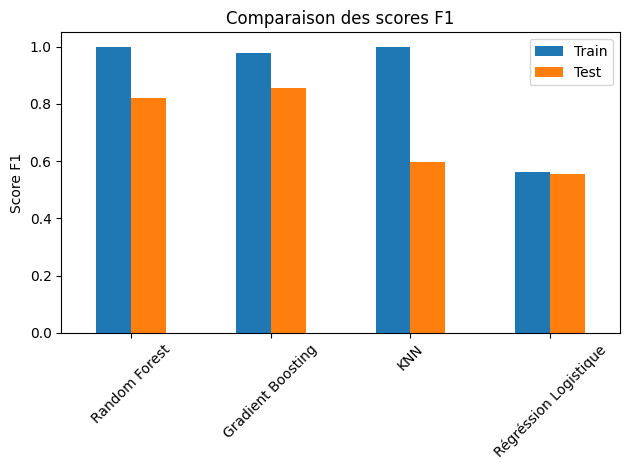

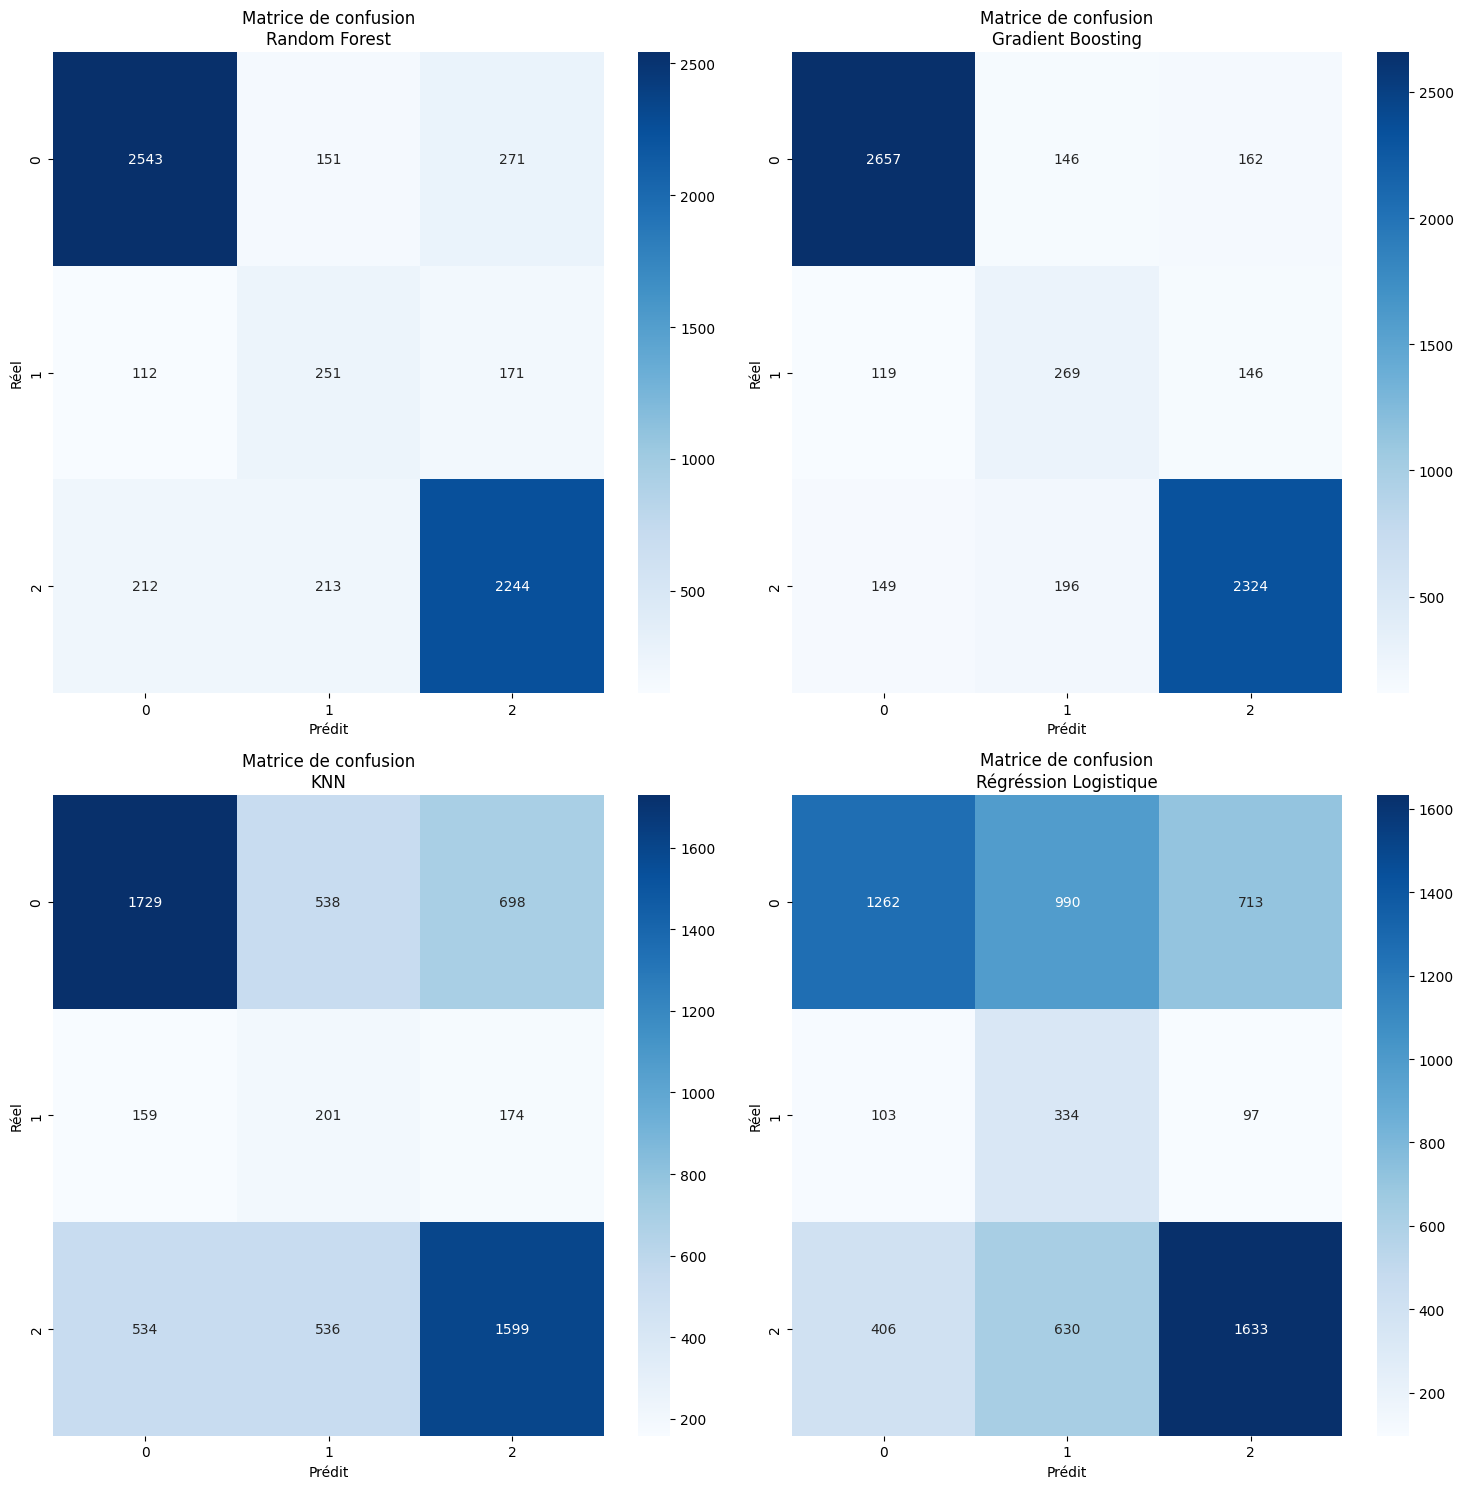


Rapport détaillé pour Gradient Boosting:
              precision    recall  f1-score   support

          -1      0.908     0.896     0.902      2965
           0      0.440     0.504     0.470       534
           1      0.883     0.871     0.877      2669

    accuracy                          0.851      6168
   macro avg      0.744     0.757     0.750      6168
weighted avg      0.857     0.851     0.854      6168



In [97]:
# Création d'un DataFrame pour la comparaison
results_df = pd.DataFrame({
    'Random Forest': rf_scores,
    'Gradient Boosting': gb_scores,
    'KNN': knn_scores,
    'Régréssion Logistique': log_scores
}).T

plt.figure(figsize=(12, 6))
results_df[['train_f1', 'test_f1']].plot(kind='bar')
plt.title('Comparaison des scores F1')
plt.ylabel('Score F1')
plt.xticks(rotation=45)
plt.legend(['Train', 'Test'])
plt.tight_layout()
plt.show()

# Matrices de confusion pour chaque modèle
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

models = {
    'Random Forest': rf_predictions,
    'Gradient Boosting': gb_predictions,
    'KNN': knn_predictions,
    'Régréssion Logistique': log_predictions
}

for ax, (name, predictions) in zip(axes, models.items()):
    conf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'Matrice de confusion\n{name}')
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Réel')

plt.tight_layout()
plt.show()

best_model = max(models.items(), key=lambda x: f1_score(y_test, x[1], average='weighted'))
print(f"\nRapport détaillé pour {best_model[0]}:")
print(classification_report(y_test, best_model[1], digits=3))

### Analyse Critique

Le Gradient Boosting surpasse les autres modèles, mais la différence avec Random Forest n'est pas énorme.

L'utilisation de SMOTE améliore la gestion des classes déséquilibrées, mais pourrait introduire du bruit.

Les grilles de paramètres pourraient être plus fines, mais au prix d'un temps de calcul plus long.

Les performances sur les égalités restent médiocres malgré l'optimisation.

Le risque de surapprentissage est présent, particulièrement pour le Gradient Boosting.

# Conclusion

Notre étude a abouti à deux résultats majeurs :

1. Développement d'un modèle prédictif :
- Précision de ~85%
- Meilleure performance avec Random Forest
- Prédiction fiable des victoires et défaites
- Difficulté persistante sur les égalités

2. Identification statistique de situations favorables :
- Stratégies optimales selon les étapes
- Actions recommandées pour maximiser les chances de gain

Perspectives d'amélioration :
- Intégration du comptage de cartes
- Exploitation des données de changement de sabot
- Étude de l'impact du système hi-lo sur la précision des prédictions